In [1]:
import pickle

import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

##### 
import warnings
warnings.filterwarnings("ignore")
#####

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *

In [2]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


Map properties
CMB experiment properties
Gets a theoretical prediction for the noise
computing the reconstruction noise


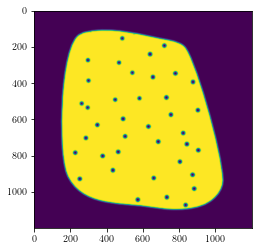

In [3]:



#####
N_runs = 2000
mask_file = 'mask_simple1200x1200.png'
psfile = 'point_sources_1200x1200.png'
psapod = 3

process = True
# number of pixels for the flat map
nX = 1200
nY = 1200
# map dimensions in degrees
sizeX = 20.
sizeY = 20.

#####


print("Map properties")


mean_field = None


# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra

print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = ftot

print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')

In [4]:
from multiprocessing import Pool
from tqdm import trange, tqdm

def process_run(_):
    cmb0Fourier = baseMap.genGRF(funlensedTT, test=False)
    cmb0 = baseMap.inverseFourier(cmb0Fourier)

    kCmbFourier = baseMap.genGRF(fKK, test=False)
    kCmb = baseMap.inverseFourier(kCmbFourier)

    lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
    lensedCmbFourier = baseMap.fourier(lensedCmb)

    fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
    lensedCmbFourier = lensedCmbFourier + fgFourier
    lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

    noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
    totalCmbFourier = lensedCmbFourier + noiseFourier
    totalCmb = baseMap.inverseFourier(totalCmbFourier)

    totalMaskedCmb = totalCmb * apodized_mask
    totalMaskedCmbFourier = baseMap.fourier(totalMaskedCmb)

    kappa_map = baseMap.computeQuadEstKappaNorm(
        fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, dataFourier=totalMaskedCmbFourier
    )
    return kappa_map


if __name__ == '__main__':
    with Pool() as pool:
        results = list(tqdm(pool.imap(process_run, range(N_runs)), total=N_runs))
    mean_field = sum(results)

f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_1200x1200_20x20.pkl', 'wb') 
pickle.dump(mean_field/N_runs, f)
f.close()


100%|██████████| 2000/2000 [2:34:24<00:00,  4.63s/it]  


In [5]:
mean_field.shape

(1200, 601)

In [6]:
np.array(results).shape

(2000, 1200, 601)

In [7]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_1200x1200_20x20.pkl', 'wb') 
pickle.dump(np.mean(results, axis=0), f)
f.close()
